# CEE 4200 Final Project Code

## Import Libraries

In [23]:
!pip install openpyxl
!pip install platypus-opt


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from platypus import NSGAII, Problem, Real

## 1. Data Collection and Formatting

### 1.1 Crop Data

In [3]:
path = '/work/'

# downloading crop land cover data
winter_crops = pd.read_excel(path + 'Cropping_Pattern_Egypt.xlsx', sheet_name = 'Winter Crops', header=4)
summer_crops = pd.read_excel(path+'Cropping_Pattern_Egypt.xlsx', sheet_name = 'Summer Crops', header=4)
nili_crops = pd.read_excel(path+'Cropping_Pattern_Egypt.xlsx', sheet_name = 'Nili Crops', header=4)

# formatting crop land cover data
def merged_cells(flag, name_vec):
  for i, rc in enumerate(name_vec):
      if (pd.isna(rc)) or (flag in str(rc)):
        name_vec[i] = name_vec[i - 1]
  return name_vec

def format_crop(df):
    df = df.drop(df.columns[0], axis=1)
    df.columns = merged_cells('Unnamed', list(df.columns))
    df['City'] = merged_cells('NaN', df['City'])
    df = df.iloc[:, :-7]
    return df

winter_crops = format_crop(winter_crops)
summer_crops = format_crop(summer_crops)
nili_crops = format_crop(nili_crops)

# downloading crop water data
winter_crop_water = pd.read_excel(path+'Crop_water_requirements.xlsx', sheet_name='Winter Crops', header=0)
summer_crop_water = pd.read_excel(path+'Crop_water_requirements.xlsx', sheet_name='Summer Crops', header=0)
nili_crop_water = pd.read_excel(path+'Crop_water_requirements.xlsx', sheet_name='Nili Crops', header=0)

winter_crop_water.columns = ['Crop', 'Delta', 'Middle', 'Upper']
summer_crop_water.columns = ['Crop', 'Delta', 'Middle', 'Upper']
nili_crop_water.columns = ['Crop', 'Delta', 'Middle', 'Upper']


### 1.2 Discharge Monitoring Data

In [4]:
# Load data from various stations provided
dis_df = pd.read_excel(path+'Nile_Stations_Historical_Discharge.xlsx', sheet_name = 'Reform')

dis_df['date'] = pd.to_datetime(dis_df[['Year', 'Month']].assign(day=1))
dis_df.rename(columns={'Unnamed: 4': 'Discharge m^3/s'}, inplace=True)

dis_df['Discharge m^3/s'].loc[dis_df['Discharge m^3/s'] < 0] = np.nan

# Group data by monitoring location
river_grouped = dis_df.groupby('River')

/tmp/ipykernel_1073/1765273645.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_df['Discharge m^3/s'].loc[dis_df['Discharge m^3/s'] < 0] = np.nan


### 1.3 Ethiopia Precipitation data

In [5]:

eth_climate_data = pd.read_csv(path + 'monthly-climatology-of-average-minimum-surface-air-temperature,-average-mean-surface-air-temperature,-average-maximum-surface-air-temperature-&-precipitation-1961-1990;-ethiopia.csv')

eth_precip = eth_climate_data[['Precipitation']] #mm/month

eth_precip_12 = pd.concat([eth_precip] * 10, ignore_index=True)

# Create the 'Month-Year' column starting from Jan 1970
date_range = pd.date_range(start='1970-01-01', periods=len(eth_precip_12), freq='MS')
eth_precip_12['Month-Year'] = pd.to_datetime(date_range, format='%Y-%m')

## 2. Modeling

### 2.1 Runoff model

This code estimates monthly runoff for a watershed by converting units, applying the Rational Method, and adding baseflow. Stochastic variability is introduced to runoff estimates.

In [6]:
# Using rational method (convert to english units and then convert back to metric units)
watershed_area = 172250 # in km^2
watershed_acres = watershed_area*247.105 # acres

eth_precip_12['Precipitation']=eth_precip_12['Precipitation']* 5.39316*10**-5 #in/hr

eth_precip_12['Runoff'] = 0.3*eth_precip_12['Precipitation']*watershed_acres # cfs
eth_precip_12['Runoff']= eth_precip_12['Runoff'] * 0.0283*3600*24*30 #m^3/day

np.random.seed(42)  


# Add stochastic variability
eth_precip_12['Runoff']= eth_precip_12['Runoff'] + np.random.uniform(-0.1, 0.1, size=len(eth_precip_12)) * eth_precip_12['Runoff']

baseflow = 2.59 *10**9 # m^3/month from research paper

i =  eth_precip_12['Runoff'] + baseflow # m^3/month


### 2.2 Natural GERD Model

natural_gerd() models the storage and outflow of the natural GERD reservoir (simple weir spillway). It begins by using a calibration curve to interpolate head elevation from storage values and sets initial parameters. Then, the storage, outflow, and elevation is calculated for each timestep.

In [7]:
def natural_gerd(i):

    # Calibration curve for storage vs head elevation from research paper
    elevation = np.array([506, 586, 606, 636, 652])
    #elevation = np.array([6, 86, 106, 136, 152])       # meters
    storage = 1e9 * np.array([0, 9.6, 17.5, 56, 80.5])  # m^3
    elevation_interp = interp1d(storage, elevation, kind='linear', fill_value="extrapolate")

    # initalize parameters
    time = len(i)
    e = 0.00512 * 1874 * 1000**2 *30  # m^3/month of evaporation for surface area of 1874m^2
    s = np.zeros(time)
    s[0] = 65 * 1000**3      # initial storage [m^3]
    q_tot = np.zeros(time)
    spill_i = np.zeros(time)      # main gated spillway @ 624.9m
    elev = np.zeros(time)         # water elevation

    for t in range(time - 1):
        # Bound the storage to prevent extrapolation issues
        s_clamped = np.clip(s[t], storage[0], storage[-1])

        elev[t] = elevation_interp(s[t])  # Interpolate elevation from calibration curve

        # Spillways outflow when storage exceeds capacity (MAGIC NUMBER: each need coefficients??)

        C = 3.3
        L = 5
        H = (elev[t] - 508)*3.28084 # converting to ft
        if 508 < elev[t]:
            spill_i[t] = (C * L * (H**1.5)) * 0.0283168* 3600 * 24 * 30  # Spillways flow [m^3/month]
        else:
            spill_i[t] = 0

        # Total outflow: Include turbine, spillway, and low-level outlet contributions
        q_tot[t] = spill_i[t]

        # Update storage
        s[t + 1] = max(s[t] + i[t] - q_tot[t] - e, 0)

    return elev, s, q_tot

### 2.3 Regulated GERD model

reg_gerd() models the storage and outflow of the GERD reservoir, incorporating turbine outflows, spillways, and hydropower generation. It begins by using a calibration curve to interpolate head elevation from storage values and sets initial parameters for evaporation, outlet area, and initial storage. The function then calculates the storage, outflow, and elevation at each time step, considering turbine operation, spillway outflows, and hydropower generation. Additionally, it calculates our indicators: irrigation deficit, hydropower deficit, and the number of times hydropower output is zero. The function returns these results along with the time series of storage, elevation, total outflow, and hydropower output.

In [8]:


def reg_gerd(i,h1,h2,w):

    # Calibration curve for storage vs head elevation from research paper
    elevation = np.array([506, 586, 606, 636, 652])     # meters
    storage = 1e9 * np.array([0, 9.6, 17.5, 56, 80.5])  # m^3
    elevation_interp = interp1d(storage, elevation, kind='linear', fill_value="extrapolate")

    # initalize parameters
    time = len(i)
    e = (0.00512 * 1874 * 1000**2) # m^3/month of evaporation for surface area of 1874m^2
    A = 4 * (np.pi * 4**2)        # area of 4 No 8m diameter low-level outlets
    s = np.zeros(time)
    s[0] = 65 * 1000**3      # initial storage [m^3]
    qi = np.zeros(time)
    qoi = np.zeros(time)
    q_tot = np.zeros(time)
    spill_i = np.zeros(time)      # main gated spillway @ 624.9m
    elev = np.zeros(time)         # water elevation
    HP = np.zeros(time)           # hydropower
    eff = 0.9                     # efficiency MAGIC NUMBER
    TL = 560                      # turbine level [m]

    for t in range(time-1):

        # Bound the storage to prevent extrapolation issues
        s_clamped = np.clip(s[t], storage[0], storage[-1])

        elev[t] = elevation_interp(s[t])  # Interpolate elevation from calibration curve

        # Turbine outflow for 590 m min operating level (MOL)
        # Turbines should be 100  m^3/sec , 13 turbines
        qi[t] = 2500*3600*24*30 if elev[t] > h1 else 0  # [m^3/month]

        qoi[t] = 1000*3600*24*30 if elev[t] < h1 else 0

        temp = elevation_interp(s[t] - qi[t]-qoi[t]+ i[t])


        # Hydropower units of W (have to divide by seconds in a month to get consistent units of W (j/s)
        HP[t] = (eff * 9807 * qi[t] * (elev[t] - TL))/(3600*24*30)

        # Spillways outflow when storage exceeds capacity (MAGIC NUMBER: each need coefficients??)
        if h2 < temp:
            spill_i[t] = (200*(temp - h2)**1.5)*3600*24*30  # width * head^1.5, capacity, 3 spillways so factor of 3 m^3 per month
        else:
            spill_i[t] = 0

        q_tot[t] = qi[t] + spill_i[t] + qoi[t]

        # Update storage
        s[t + 1] = max(s[t] + i[t + 1] - q_tot[t] - e, 0)
    
    irr_def = np.mean(abs(q_tot - w))
    hyd_def = np.mean(abs((HP/10**9)-1))
    hyd_zero = len(np.where(HP == 0)[0])

    return irr_def, hyd_def, hyd_zero, s, elev, q_tot, HP



### 2.4 Lake Nasser Model

nasser() models the storage, outflow, and elevation of Lake Nasser. It starts by using a calibration curve to interpolate head elevation from storage values and initializes the reservoir storage, outflow, and elevation. The function then iterates through each timestep to calculate the new storage after accounting for inflow, outflow, and evaporation. If the new storage exceeds the maximum capacity, excess water is released, and if the storage falls below the required outflow, the flow is adjusted. The function returns the time series for reservoir volume, released water, outflow, and elevation over time.

In [9]:
def nasser(s, q, i,e):

    # Calibration curve for storage vs head elevation from research paper
    naser_elevation = np.array([120, 147, 155,163,170,175,182])     # meters
    naser_storage = 1e9 * np.array([0, 23, 40, 60, 80,100,140])  # m^3
    naser_elevation_interp = interp1d(naser_storage, naser_elevation, kind="linear", fill_value="extrapolate")

    # Initialize lists with starting values
    res_vol = [s]
    dumped_list = [0]
    out_list = [0]  # Start with an initial outflow value
    elev =[naser_elevation_interp(s)]

    for x in range(1, len(q)):  # Use `len(q)` or `len(i)` instead of `len(roseries)`
        # Test 1 - new reservoir storage after outflow
        test1 = res_vol[x-1] + i.iloc[x] - q.iloc[x] - e

        # Test 2 - new reservoir storage before outflow removed
        test2 = res_vol[x-1] + i.iloc[x] - e

        dump = 0
        out = 0
        new_s = 0

        # Check if new storage after outflow is greater than max storage, dump excess
        if test1 > s:
            dump = test1 - s
            new_s = s

        # Check if new storage before outflow is less than downstream requirements
        elif test2 < q.iloc[x]:
            new_s = 0
            out = test2

        else:
            new_s = test1
            out = q.iloc[x]

        # Append new data
        res_vol.append(new_s)
        dumped_list.append(dump)
        out_list.append(out)
        elev.append(naser_elevation_interp(new_s))  # Append the calculated outflow
    
    return res_vol, dumped_list, out_list, elev


### 2.5 Crop Water Demand Model

This script calculates the water requirements for different crops across three regions (Delta, Middle, and Upper) for three seasons (Winter, Summer, and Nili). calculate_water_requirements_by_region() computes the water requirement for each crop by multiplying the crop area by the respective water requirement for the region and summing the results. This is used to find the monthly water demand for Egypt.

In [10]:
# Cultivated land data
winter_land_data = winter_crops
summer_land_data = summer_crops
nili_land_data = nili_crops

# Function to calculate water requirements by region for each season
def calculate_water_requirements_by_region(land_data, water_data, region_col):
    total_water_requirement = pd.Series(0, index=land_data.index)

    # Create a dictionary for water requirements by crop for the specific region
    water_dict = water_data.set_index('Crop')[region_col].to_dict()

    # Multiply land area by water requirement for each crop
    for crop, water_need in water_dict.items():
        if crop in land_data.columns:
            total_water_requirement += land_data[crop] * water_need

    return total_water_requirement

# Store results by season and region
results = {'Delta': {},'Middle': {},'Upper': {}}

# Calculate water requirements for each season and each region
for region, column_name in zip(['Delta', 'Middle', 'Upper'], ['Delta', 'Middle', 'Upper']):
    results[region]['Winter'] = calculate_water_requirements_by_region(winter_land_data, winter_crop_water, column_name)
    results[region]['Summer'] = calculate_water_requirements_by_region(summer_land_data, summer_crop_water, column_name)
    results[region]['Nili'] = calculate_water_requirements_by_region(nili_land_data, nili_crop_water, column_name)

# Initialize a dictionary to hold summed results
summed_results = {
    'Place and season': ['Total water (m^3)'],  # Placeholder for a total row
    'Total_Winter_Water_Delta': [0],
    'Total_Winter_Water_Middle': [0],
    'Total_Winter_Water_Upper': [0],
    'Total_Summer_Water_Delta': [0],
    'Total_Summer_Water_Middle': [0],
    'Total_Summer_Water_Upper': [0],
    'Total_Nili_Water_Delta': [0],
    'Total_Nili_Water_Middle': [0],
    'Total_Nili_Water_Upper': [0],
}

# Sum water requirements for each region and season
for region in ['Delta', 'Middle', 'Upper']:
    for season in ['Winter', 'Summer', 'Nili']:
        summed_results[f'Total_{season}_Water_{region}'][0] += results[region][season].sum()

combined_results = pd.DataFrame(summed_results)


# Define the months for each season
winter_months = ['November', 'December', 'January', 'February', 'March', 'April']
summer_months = ['May', 'June', 'July', 'August', 'September', 'October']
nili_months = ['July', 'August', 'September', 'October']

# Initialize a dictionary to hold monthly water requirements
monthly_water_requirements = {month: 0 for month in 
                              ['January', 'February', 'March', 'April',
                                'May', 'June', 'July', 'August', 'September', 'October','November', 'December']}

# Function to distribute water requirements equally across months
def distribute_water(total_water, months):
    water_per_month = total_water / len(months)
    for month in months:
        monthly_water_requirements[month] += water_per_month

# Distribute water requirements for each region and season
for region in ['Delta', 'Middle', 'Upper']:
    # Distribute Winter water
    distribute_water(combined_results[f'Total_Winter_Water_{region}'][0], winter_months)
    # Distribute Summer water
    distribute_water(combined_results[f'Total_Summer_Water_{region}'][0], summer_months)
    # Distribute Nili water
    distribute_water(combined_results[f'Total_Nili_Water_{region}'][0], nili_months)

# Create a pandas Series for better readability
monthly_crop_water = pd.Series(monthly_water_requirements)

ordered_months = ['January', 'February', 'March', 'April', 'May', 
                  'June', 'July', 'August', 'September', 'October', 
                  'November', 'December']

# Create a pandas Series with months ordered from January to December
ordered_monthly_water_vector = pd.Series(
    {month: monthly_water_requirements[month] for month in ordered_months}
)

# Create a pandas Series with months ordered from January to December
ordered_monthly_water_vector = pd.Series(
    {month: monthly_water_requirements[month] for month in ordered_months}
)

crop_water_monthly = np.tile(ordered_monthly_water_vector.values, 120 // 12 + 1)[:120]

crop_water_monthly = pd.Series(crop_water_monthly, name="Monthly_Water_Requirements")

total_crop_water_demand = sum(crop_water_monthly)

### 

### 3. Optimization Using NGSA II

This Python code implements a multi-objective optimization for the GERD system using the NSGA-II (Non-dominated Sorting Genetic Algorithm II). The goal of the optimization is to find an optimal set of h1 and h2 values that balance multiple competing irrigation and hydropower generation objectivies

Indicators:
- Irrigation Deficit (`irr_def`): Average difference between the irrigation water demand and the actual supply available from the dam over 10 years
- Hydropower Deficit (`hyd_def`): Average difference between the expected and actual hydropower generation from the dam over 10 years
- Hydropower Zero (`hyd_zero`): A measure of times when hydropower generation is zero over 10 years

The optimization problem has two decision variables, `h1` and `h2', which represent turbine height and spillway height and the optimization seeks to minimize the irrigation deficit, hydropower deficit, and hydropower zero simultaneously.

Code Overview:
1. fitness(h1, h2, inflow, demand) computes the three indicators based on the decision variables (`h1`, `h2`), inflow data, and water demand. reg_gerd() is used to calculate these values.

2. Optimization Problem Definition: The `GERDOptimization` class defines the optimization problem:
   - 2 decision variables(`h1` and `h2`).
   - 3 objectives: irrigation deficit, hydropower deficit, and hydropower zero.
   - The bounds for `h1` and `h2`.

3. NSGA-II Algorithm: The optimization problem is solved using the NSGA-II algorithm, which generates a Pareto front. The algorithm evaluates 500 potential solutions using a population size of 20, and for each solution, the corresponding values of the three objectives are computed.

4. Results Analysis:
   - The closest point to the utopia (ideal solution) is determined by calculating the distance between each solution in the Pareto front and a predefined utopia point. The closest solution represents the most desirable trade-off between irrigation and hydropower deficits.

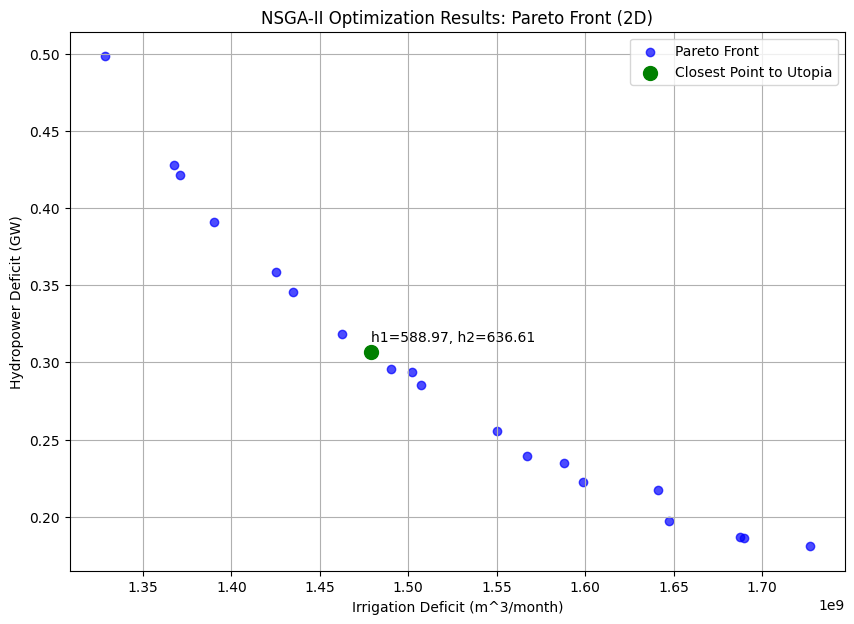

Closest point to utopia: [1.47887375e+09 3.06475051e-01 3.00000000e+00]
Decision variables (h1, h2) for closest point: h1=588.97, h2=636.61


In [11]:
# Define the fitness function (multi-objective)
def fitness(h1, h2, inflow, demand):
    irr_def, hyd_def, hyd_zero, _, _, _, _ = reg_gerd(inflow, h1, h2, demand)
    return irr_def, hyd_def, hyd_zero

# Define the optimization problem
class GERDOptimization(Problem):
    def __init__(self, inflow, demand):
        # Create a problem with 2 decision variables and 3 objectives
        super(GERDOptimization, self).__init__(2, 3)  # 2 variables, 3 objectives
        self.types[:] = [Real(550, 650), Real(610, 700)]  # Bounds for h1 and h2
        self.inflow = inflow
        self.demand = demand

    def evaluate(self, solution):
        h1, h2 = solution.variables
        irr_def, hyd_def, hyd_zero = fitness(h1, h2, self.inflow, self.demand)
        solution.objectives[:] = [irr_def, hyd_def, hyd_zero]

w = 2000*30*24*3600 # Agricultural water demand

# Load data for inflow and demand (replace with actual data)
inflow = np.loadtxt('gerd_inflow.txt', skiprows=2)  # Example inflow data
demand = w  # Replace with actual demand value

# Create the problem instance
problem = GERDOptimization(inflow, demand)

# Set up and run NSGA-II
algorithm = NSGAII(problem, population_size=20)  # Population size
algorithm.run(500)  # Total evaluations (adjust as needed)

# Extract results
results = np.array([[s.objectives[0], s.objectives[1], s.objectives[2]] for s in algorithm.result])
h1_h2_values = np.array([[s.variables[0], s.variables[1]] for s in algorithm.result])

# Define the utopia point
utopia_point = np.array([1.48e9, 0.2, 0])  # Ideal values for all 3 indicators

# Compute the distance from each Pareto point to the utopia point
distances = np.sqrt(np.sum((results - utopia_point) ** 2, axis=1))
closest_index = np.argmin(distances)
closest_point = results[closest_index]
closest_h1_h2 = h1_h2_values[closest_index]

utopia_h1 = closest_h1_h2[0]
utopia_h2 = closest_h1_h2[1]

plt.figure(figsize=(10, 7))

plt.scatter(results[:, 0], results[:, 1], c='blue', label='Pareto Front', alpha=0.7)

plt.scatter(closest_point[0], closest_point[1], color='green', s=100, label='Closest Point to Utopia', zorder=5)
plt.text(closest_point[0], closest_point[1]+0.007,
         f"h1={closest_h1_h2[0]:.2f}, h2={closest_h1_h2[1]:.2f}",
         fontsize=10, color='black', zorder=6)  # Higher zorder for text

plt.xlabel('Irrigation Deficit (m^3/month)')
plt.ylabel('Hydropower Deficit (GW)')
plt.title('NSGA-II Optimization Results: Pareto Front (2D)')
plt.legend()
plt.grid(True)

plt.show()

print(f"Closest point to utopia: {closest_point}")
print(f"Decision variables (h1, h2) for closest point: h1={closest_h1_h2[0]:.2f}, h2={closest_h1_h2[1]:.2f}")


### 4. Plotting Code

### 4.1 Natural GERD

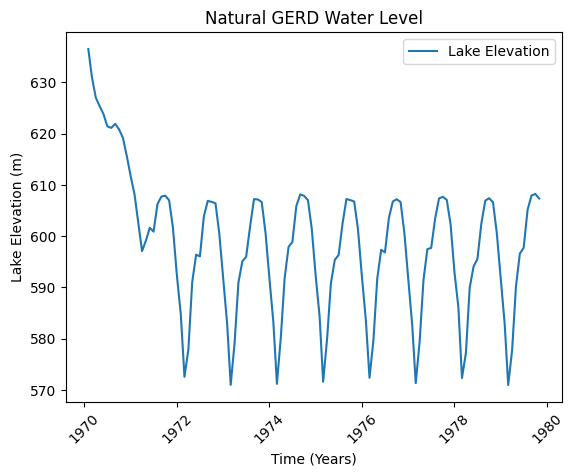

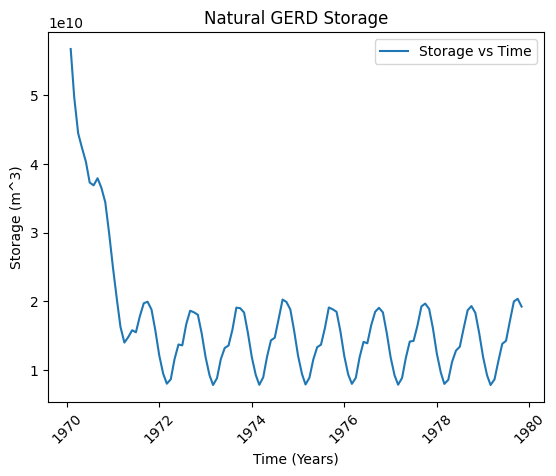

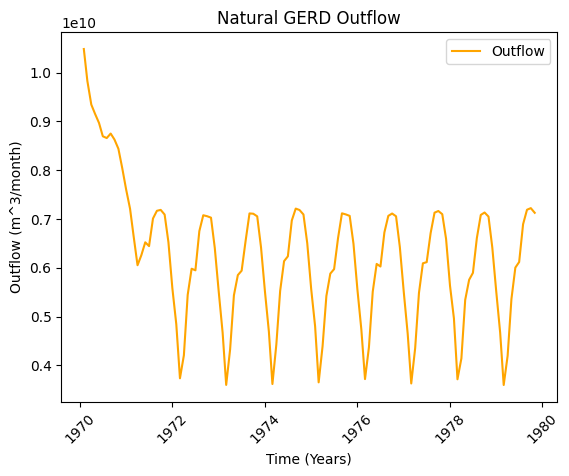

In [12]:
elev_nat, s_nat, q_tot_nat = natural_gerd(i)

# Plot Lake Elevation
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], elev_nat[1:-1], label='Lake Elevation')
plt.xlabel('Time (Years)')
plt.ylabel('Lake Elevation (m)')
plt.title('Natural GERD Water Level')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every two years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Storage vs Time
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], s_nat[1:-1], label='Storage vs Time')
plt.xlabel('Time (Years)')
plt.ylabel('Storage (m^3)')
plt.title('Natural GERD Storage')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


# Plot Outflow Production
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], q_tot_nat[1:-1], label='Outflow', color='orange')
plt.xlabel('Time (Years)')
plt.ylabel('Outflow (m^3/month)')
plt.title('Natural GERD Outflow')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


plt.show()

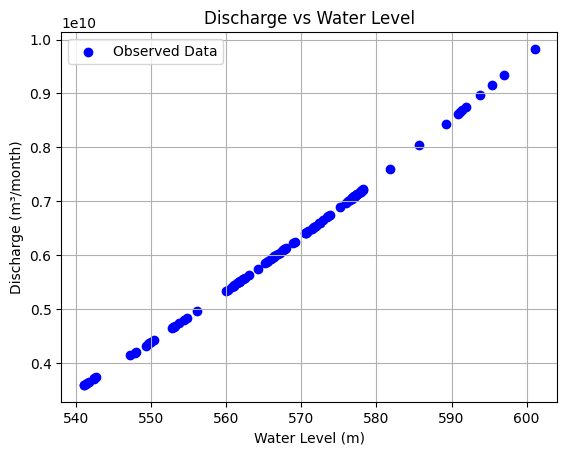

In [13]:
# Stage Discharge Curve for Natural GERD
elev_nat_curve = elev_nat
elev_nat_curve[1:-1] = elev_nat[1:-1]- (np.min(elev_nat[1:-1])-1)
# Extract relevant data and sort by elevation
elev_sorted_indices = np.argsort(elev_nat_curve[1:-1])  # Indices to sort elev in ascending order
elev_sorted = elev_nat_curve[elev_sorted_indices][:-1] 
q_tot_sorted = q_tot_nat[elev_sorted_indices][:-1]

plt.scatter(elev_sorted[:-1]+ 540, q_tot_sorted[:-1], color='blue', label='Observed Data')
plt.xlabel('Water Level (m)')
plt.ylabel('Discharge (m³/month)')
plt.title('Discharge vs Water Level')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 Regulated GERD

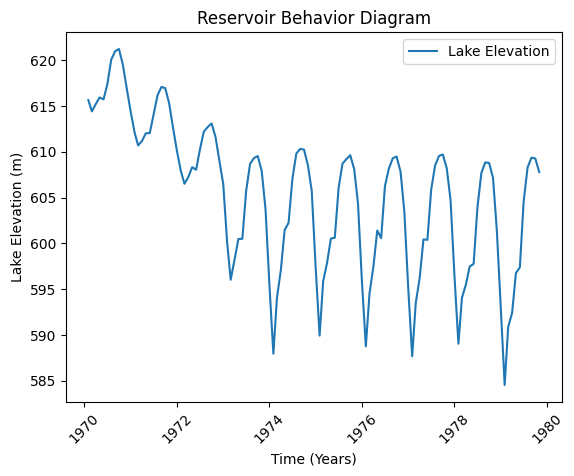

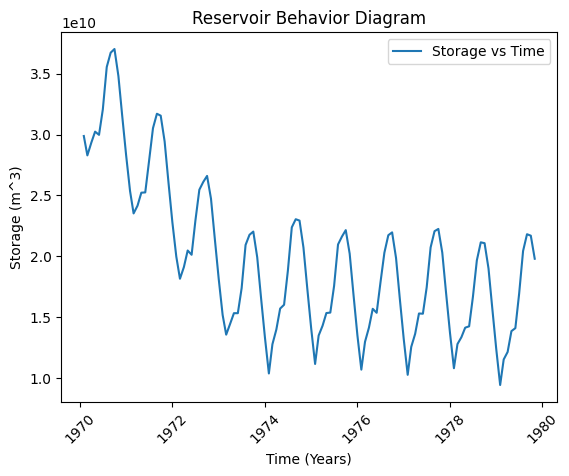

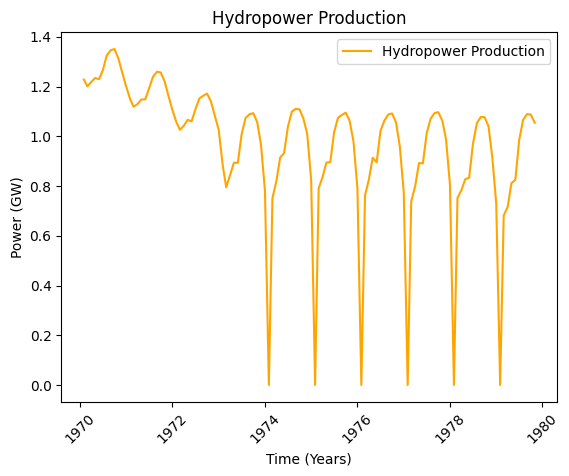

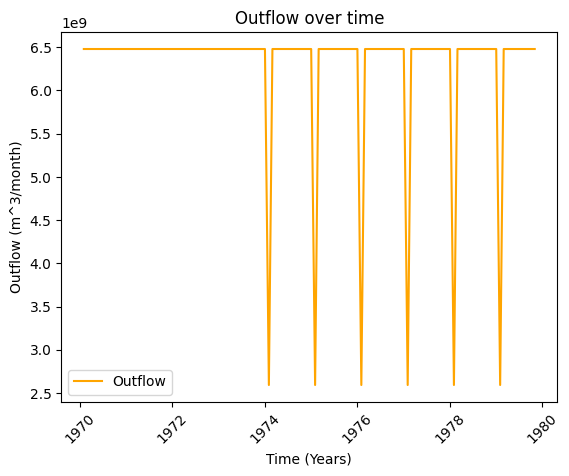

In [14]:
# Ag. Demand
w = 1425*30*24*3600

# Original h1 and h2
irr_def_reg, hyd_def_reg,hyd_zero_reg, s_reg, elev_reg, q_tot_reg, HP_reg = reg_gerd(i,590,624,w)

# Plot Lake Elevation
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], elev_reg[1:-1], label='Lake Elevation')
plt.xlabel('Time (Years)')
plt.ylabel('Lake Elevation (m)')
plt.title('Reservoir Behavior Diagram')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every two years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Storage vs Time
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], s_reg[1:-1], label='Storage vs Time')
plt.xlabel('Time (Years)')
plt.ylabel('Storage (m^3)')
plt.title('Reservoir Behavior Diagram')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Hydropower Production
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], HP_reg[1:-1] / 1e9, label='Hydropower Production', color='orange')
plt.xlabel('Time (Years)')
plt.ylabel('Power (GW)')
plt.title('Hydropower Production')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Outflow Production
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], q_tot_reg[1:-1], label='Outflow', color='orange')
plt.xlabel('Time (Years)')
plt.ylabel('Outflow (m^3/month)')
plt.title('Outflow over time')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

### 4.3 Optimized Regulated GERD

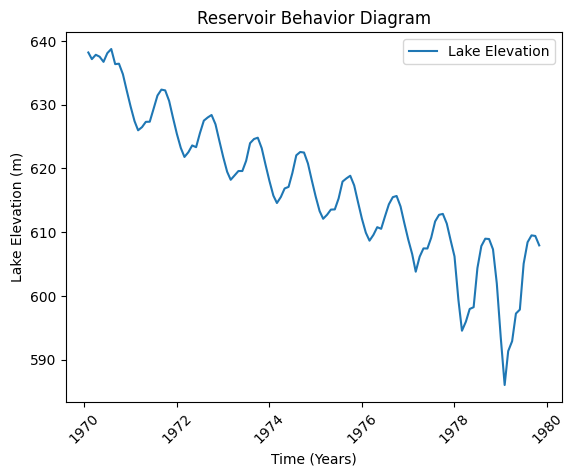

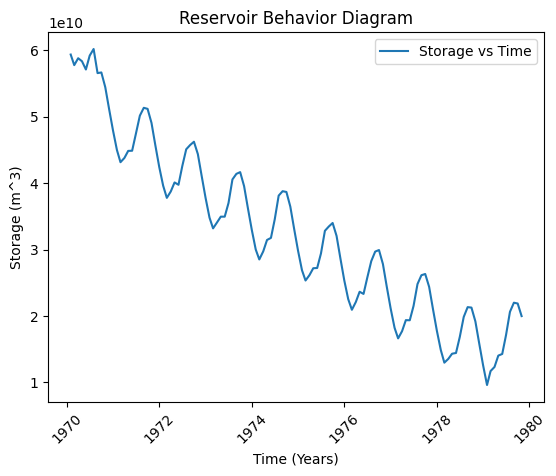

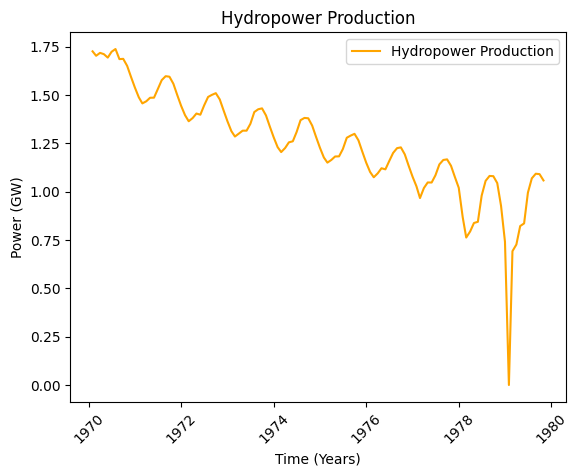

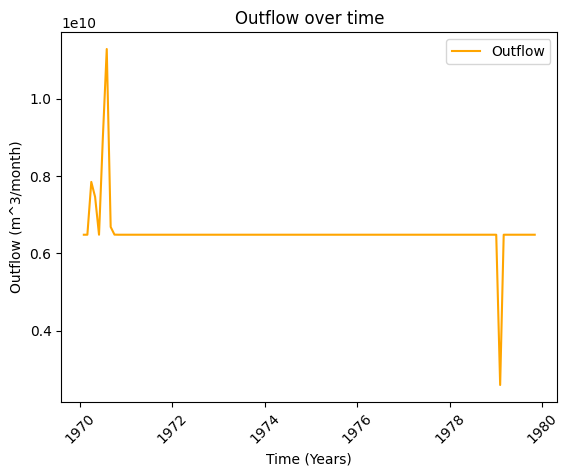

In [15]:
h1= utopia_h1
h2 = utopia_h2

# Optimized h1 and h2
irr_def_opt, hyd_def_opt, hyd_zero_opt, s_opt, elev_opt, q_tot_opt, HP_opt = reg_gerd(i,h1,h2,w)


# Plot Lake Elevation
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], elev_opt[1:-1], label='Lake Elevation')
plt.xlabel('Time (Years)')
plt.ylabel('Lake Elevation (m)')
plt.title('Reservoir Behavior Diagram')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every two years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Storage vs Time
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], s_opt[1:-1], label='Storage vs Time')
plt.xlabel('Time (Years)')
plt.ylabel('Storage (m^3)')
plt.title('Reservoir Behavior Diagram')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Hydropower Production
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], HP_opt[1:-1] / 1e9, label='Hydropower Production', color='orange')
plt.xlabel('Time (Years)')
plt.ylabel('Power (GW)')
plt.title('Hydropower Production')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Plot Outflow Production
plt.figure()
plt.plot(eth_precip_12['Month-Year'][1:-1], q_tot_opt[1:-1], label='Outflow', color='orange')
plt.xlabel('Time (Years)')
plt.ylabel('Outflow (m^3/month)')
plt.title('Outflow over time')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

### 4.4 Lake Nasser Plots

In [16]:
import pandas as pd
import numpy as np

# Define the start and end date for the 10-year period
start_date = pd.Timestamp("1970-01-01")
end_date = start_date + pd.DateOffset(years=10)

# Iterate over each river group and filter the data for the 10-year period
for river, group in river_grouped:
    if river == "Dongola_Nile_Sudan":
        dongola = group[(group['date'] >= start_date) & (group['date'] < end_date)].reset_index(drop=True)
        
    elif river == "Aswan Dam_Nile":
        aswan = group[(group['date'] >= start_date) & (group['date'] < end_date)].reset_index(drop=True)
        
    elif river == "Malakal_White Nile":
        white = group[(group['date'] >= start_date) & (group['date'] < end_date)].reset_index(drop=True)

# Creating Lake Nasser DataFrames for natural, regulated, and optimized conditions
lake_nasser_nat = pd.DataFrame({
    'Aswan': aswan['Discharge m^3/s'], 
    'GERD': q_tot_nat,
    'white': white['Discharge m^3/s'],
    'Date': aswan['date']
})
lake_nasser_reg = pd.DataFrame({
    'Aswan': aswan['Discharge m^3/s'], 
    'GERD': q_tot_reg,
    'white': white['Discharge m^3/s'],
    'Date': aswan['date']
})
lake_nasser_opt = pd.DataFrame({
    'Aswan': aswan['Discharge m^3/s'], 
    'GERD': q_tot_opt,
    'white': white['Discharge m^3/s'],
    'Date': aswan['date']
})


def calculate_lake_nasser(lake_nasser, s_nas, egypt_demand, sudan_demand):
    
    # Calculate monthly demands
    demand_winter_months = (egypt_demand / 12) * 0.8
    demand_summer_months = (egypt_demand / 12) * 1.2
    sudan_demand_mth = sudan_demand / 12

    lake_nasser['demand'] = lake_nasser['Date'].dt.month.apply(
        lambda month: demand_winter_months if month in [1, 2, 3, 10, 11, 12] else demand_summer_months
    )

    q = lake_nasser['demand']  # Outflow in m³/month
    e = 0.00512 * 5250 * 1000**2 * 30  # Evaporation in m³/month
    i_nasser = (lake_nasser['white'] * 3600 * 24 * 30 + lake_nasser['GERD'] - sudan_demand_mth).shift(1)  # Shift inflow
    
    # Run the model
    res_vol, dumped_list, out_list, elev = nasser(s_nas, q, i_nasser, e)

    lake_nasser['reservoir_vol'] = res_vol
    lake_nasser['dumped'] = dumped_list
    lake_nasser['outflow_adj'] = out_list
    lake_nasser['elevation'] = elev

    return lake_nasser

def plot_lake_nasser_volumes(lake_nasser_nat, lake_nasser_reg, lake_nasser_opt, demand):
    """
    Plots reservoir volumes for Lake Nasser under natural, regulated, and optimized conditions.

    Parameters:
    - lake_nasser_nat: DataFrame for natural conditions with 'Date' and 'reservoir_vol' columns.
    - lake_nasser_reg: DataFrame for regulated conditions with 'Date' and 'reservoir_vol' columns.
    - lake_nasser_opt: DataFrame for optimized conditions with 'Date' and 'reservoir_vol' columns.
    - demand: egypt demand in BCM
    """
    plt.figure(figsize=(12, 6))

    # Plot for natural conditions
    plt.plot(
        lake_nasser_nat['Date'], lake_nasser_nat['reservoir_vol'], 
        label="GERD Natural Conditions", color="blue"
    )

    # Plot for regulated conditions
    plt.plot(
        lake_nasser_reg['Date'], lake_nasser_reg['reservoir_vol'], 
        label="GERD Regulated Conditions", color="green"
    )

    # Plot for optimized conditions
    plt.plot(
        lake_nasser_opt['Date'], lake_nasser_opt['reservoir_vol'], 
        label="GERD Optimized Conditions", color="red"
    )

    # Adding plot titles and labels
    plt.title("Lake Nasser Reservoir Volume Over Time (demand = " + str(demand) + " BCM)", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Reservoir Volume (m³)", fontsize=14)
    plt.ticklabel_format(style='plain', axis='y')  # Prevent scientific notation on the y-axis
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show the plot
    plt.tight_layout()
    plt.show()



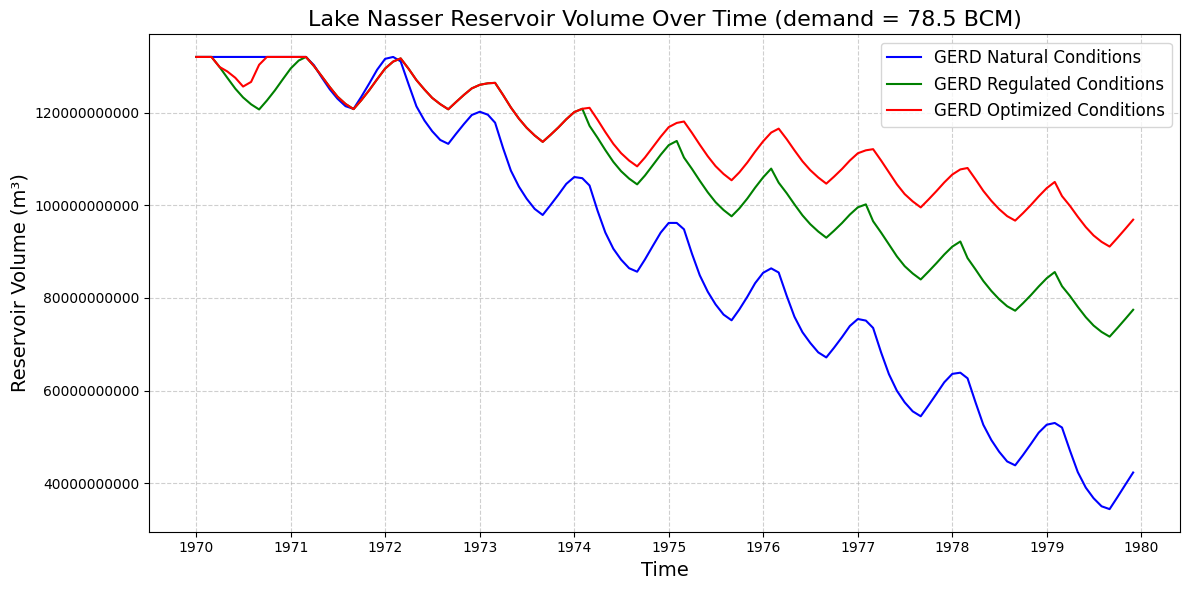

In [17]:
# Define constants
s_nas = 132 * 1000**3  # Initial reservoir volume in m³
egypt_demand = 78.5 * 10**9  # Annual demand in m³
sudan_demand = 25 * 10**9  # Annual demand in m³

# Calculate for all three datasets
lake_nasser_nat = calculate_lake_nasser(lake_nasser_nat, s_nas, egypt_demand, sudan_demand)
lake_nasser_reg = calculate_lake_nasser(lake_nasser_reg, s_nas, egypt_demand, sudan_demand)
lake_nasser_opt = calculate_lake_nasser(lake_nasser_opt, s_nas, egypt_demand, sudan_demand)

plot_lake_nasser_volumes(lake_nasser_nat, lake_nasser_reg, lake_nasser_opt, (egypt_demand/10**9))


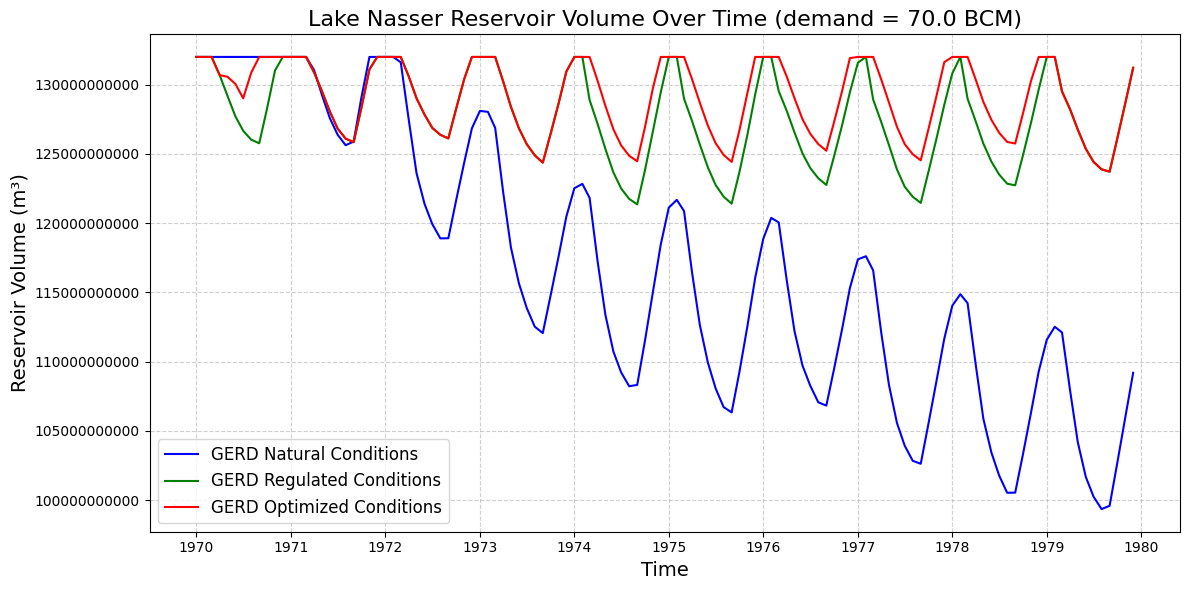

In [18]:
# Define constants
s_nas = 132 * 1000**3  # Initial reservoir volume in m³
egypt_demand = 70 * 10**9  # Annual demand in m³
sudan_demand = 25 * 10**9  # Annual demand in m³

# Calculate for all three datasets
lake_nasser_nat = calculate_lake_nasser(lake_nasser_nat, s_nas, egypt_demand, sudan_demand)
lake_nasser_reg = calculate_lake_nasser(lake_nasser_reg, s_nas, egypt_demand, sudan_demand)
lake_nasser_opt = calculate_lake_nasser(lake_nasser_opt, s_nas, egypt_demand, sudan_demand)

plot_lake_nasser_volumes(lake_nasser_nat, lake_nasser_reg, lake_nasser_opt, (egypt_demand/10**9))


### 4.4 Comparison Plots

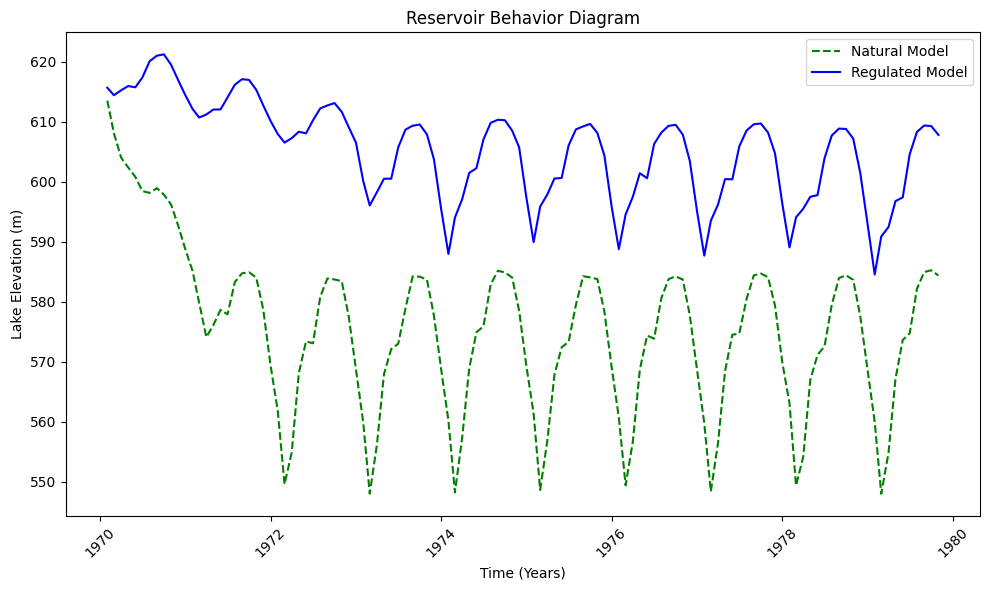

In [19]:

# Combined plot for Lake Elevation
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(eth_precip_12['Month-Year'][1:-1], elev_nat[1:-1]+547, label='Natural Model', color = 'green', linestyle='--')
plt.plot(eth_precip_12['Month-Year'][1:-1], elev_reg[1:-1], label='Regulated Model', color = 'blue', linestyle='-')

plt.xlabel('Time (Years)')
plt.ylabel('Lake Elevation (m)')
plt.title('Reservoir Behavior Diagram')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every two years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


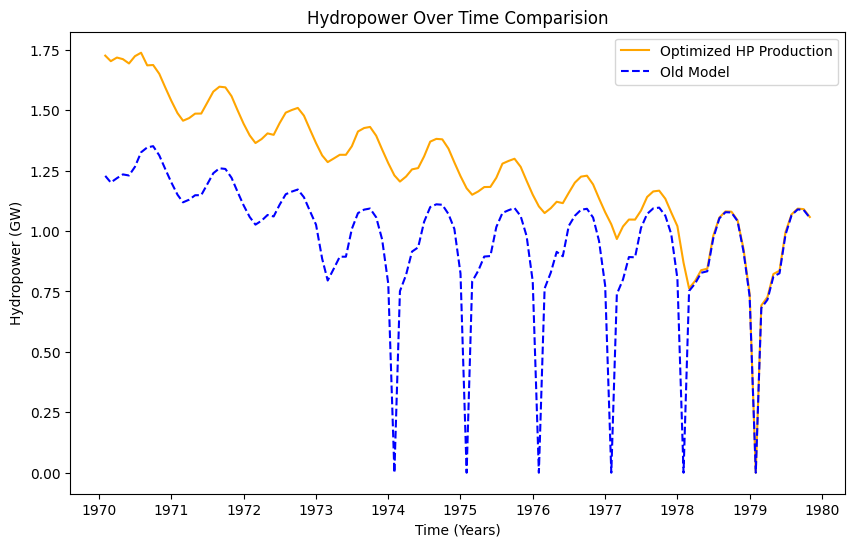

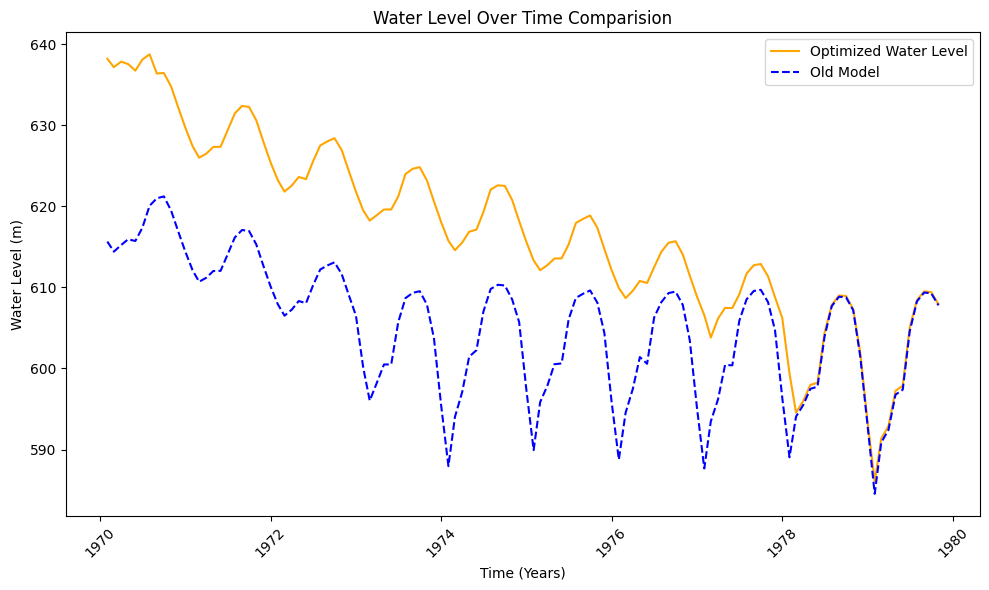

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Combined plot for Hydropower Production
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(eth_precip_12['Month-Year'][1:-1], HP_opt[1:-1] / 1e9, label='Optimized HP Production', color='orange', linestyle='-')
plt.plot(eth_precip_12['Month-Year'][1:-1], HP_reg[1:-1] / 1e9, label='Old Model', color='blue', linestyle='--')

plt.xlabel('Time (Years)')
plt.ylabel('Hydropower (GW)')
plt.title('Hydropower Over Time Comparision')
plt.legend()

# Combined plot for Lake Elevation
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.plot(eth_precip_12['Month-Year'][1:-1],  elev_opt[1:-1], label='Optimized Water Level', color='orange', linestyle='-')
plt.plot(eth_precip_12['Month-Year'][1:-1],  elev_reg[1:-1], label='Old Model', color='blue', linestyle='--')

plt.xlabel('Time (Years)')
plt.ylabel('Water Level (m)')
plt.title('Water Level Over Time Comparision')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every two years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


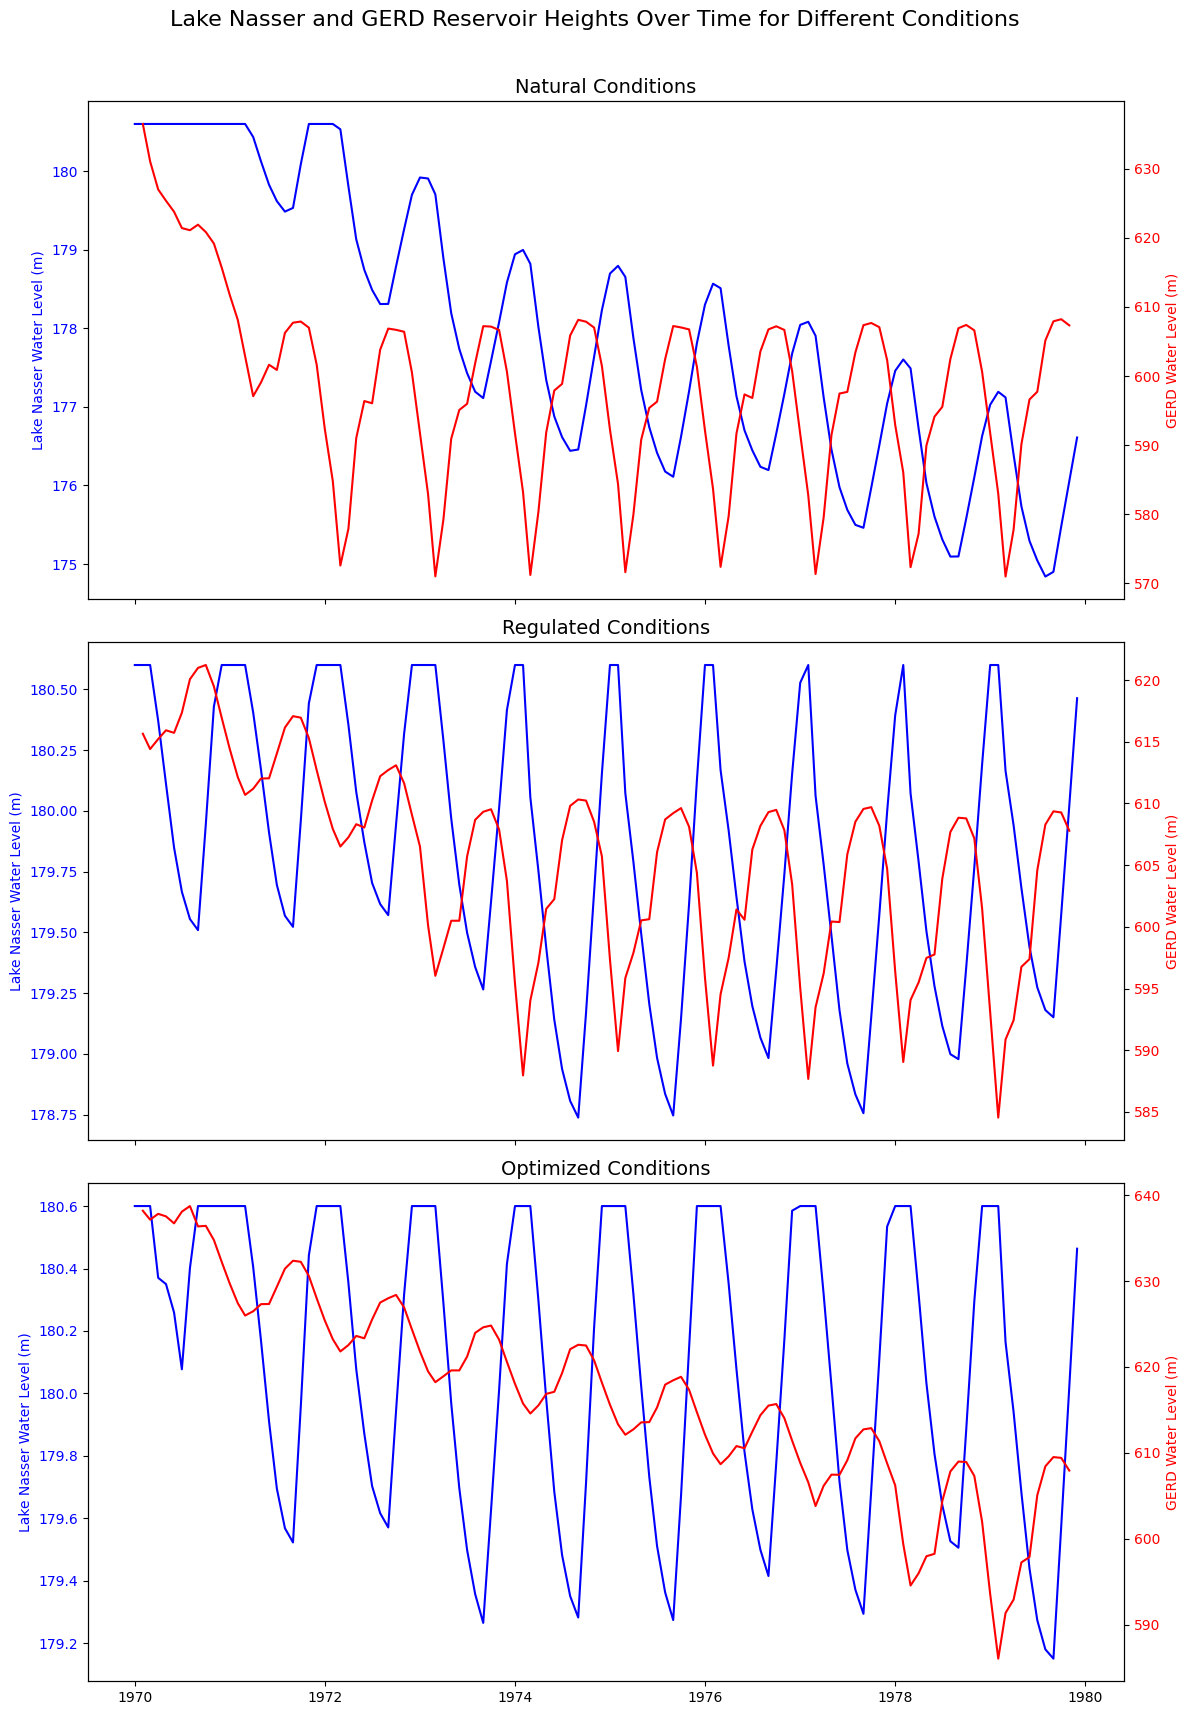

In [21]:
# Define the interpolations
naser_elevation = np.array([120, 147, 155, 163, 170, 175, 182])  # meters
naser_storage = 1e9 * np.array([0, 23, 40, 60, 80, 100, 140])  # m^3
naser_elevation_interp = interp1d(naser_storage, naser_elevation, kind="linear", fill_value="extrapolate")

gerd_elevation = np.array([506, 586, 606, 636, 652])
gerd_storage = 1e9 * np.array([0, 9.6, 17.5, 56, 80.5])  # m^3
elevation_interp = interp1d(gerd_storage, gerd_elevation, kind='linear', fill_value="extrapolate")

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

datasets = [
    (lake_nasser_nat, s_nat, "Natural Conditions"),
    (lake_nasser_reg, s_reg, "Regulated Conditions"),
    (lake_nasser_opt, s_opt, "Optimized Conditions"),
]

colors = ['blue', 'blue', 'blue'] 

# Loop through datasets to create individual plots
for i, (lake_nasser, storage, title) in enumerate(datasets):
    ax1 = axes[i]
    
    # Plot Lake Nasser water level
    ax1.plot(
        lake_nasser['Date'], 
        naser_elevation_interp(lake_nasser['reservoir_vol']), 
        color=colors[i],
        label="Lake Nasser Water Level"
    )
    ax1.set_ylabel("Lake Nasser Water Level (m)", color=colors[i])
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.tick_params(axis='y', labelcolor=colors[i])
    ax1.set_title(f"{title}", fontsize=14)
    
    # Add secondary y-axis for GERD water level
    ax2 = ax1.twinx()
    ax2.plot(
        eth_precip_12['Month-Year'][1:-1], 
        elevation_interp(storage[1:-1]), 
        color='red', 
        label="GERD Water Level"
    )
    ax2.set_ylabel("GERD Water Level (m)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')


axes[-1].xaxis.set_major_locator(mdates.YearLocator(2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

fig.suptitle("Lake Nasser and GERD Reservoir Heights Over Time for Different Conditions", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout for the suptitle

plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59903108-6a9e-4e96-bff2-648ba20455bb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>